# Introduction to `imreduce`

Joshua Loyal, January 2018

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from mpl_toolkits.mplot3d import Axes3D
from plotting_utils import label_line, label_component, abline
from loyalpy.annotations import label_abline
from plotting_utils import Arrow3D

mpl.rcParams['figure.figsize'] = (10, 8)

`imreduce` is a library for sufficient dimension reduction (SDR) using inverse moment methods. This is not a common technique, but can be a powerful tool in the right situation. This document is designed to introduce the concept of SDR to those familiary with other more common unsupervised dimension reduction techniques like Principal Component Analysis (PCA). When following along it will be helpful to keep Principal Component Analysis (PCA) in mind. While PCA is not an SDR technique, it serves the same purpose: to reduce the number of features in a dataset.

We'll start with a brief introduction to sufficient dimension reduction. This section elaborates on the purpose of SDR as well as in what situations it should be used. Following this introduction is a comparison of PCA with Sliced Inverse Regression (SIR). SIR is an inverse moment method that results in sufficient dimension reduction. The implementation of which is found in the `imreduce` package.

# What is Sufficient Dimension Reduction?

Let's say we have some data, and we want to predict some feature, $y$, using a collection of other features, $\mathbf{X}$. In other words, we want to gain some insight about the conditional distribution $y|\mathbf{X}$. However, when the number of features is high, it is common to remove irrelavent features before moving onto the prediction step. This removal of features is what is meant by dimension reduction. We are *reducing* the number of columns (aka *dimensions*) in our dataset.

Those familiar with dimension reduction may be thinking: "*I'll use PCA or t-SNE for this!*". While these techniques are great, they fall under the category of *unsupervised* dimension reduction. Notice that the unsupervised setup is very different than the situation described above. In unsupervised learning we are only concerned with the distribution of $\mathbf{X}$ itself. No y involved. For example, PCA would reduce the number of features by identifying a small set of directions that explains the greatest variation in the data. This set of directions is known as a subspace. However, there is no reason to believe that this subspace contains any information about the relationship between $y$ and $\mathbf{X}$. Information about $y$ could be orthogonal to this space. This is because PCA did not use information about $y$ when determining the directions of variation.

In order to avoid the situation above, **sufficient dimension reduction** is all about keeping the relationship between $\mathbf{X}$ and $y$ in mind. The goal is to find a small set of directions that can replace $\mathbf{X}$ without loss of information on the conditional distribution $y|\mathbf{X}$. This special subspace is called the **central subspace**, and is labeled with the symbol $S(\mathbf{X})$. In other words, if we restrict out attention to this smaller subspace, $S(\mathbf{X})$, we would find that the conditional distribution $y|S(\mathbf{X})$ is the same as the distribution $y|\mathbf{X}$. But we now have a much smaller set of features! This would allow us to better visualize our data and possibly gain deeper insights.

## Example: Surfaces in 3D

Let's focus on a concrete example: A surface in three-dimensions. In this case, we have two features $x_1$ and $x_2$ that live on a plane in 2-dimensions. In addition, each pair of points, $(x_1, x_2)$, is associated with the height of the surface, $y$, that lies above it. In this example, we will focus on a parabolic surface: $y = x_1^2$. In terms of features and targets, we have a dataset of two features, ($x_1$, $x_2$), and the target is the height of the surface, $y$.

What are the possible subspaces associated with this dataset? They are subspaces of the $x_1x_2$-plane. This is a plane in two-dimensions. The subspaces of this plane correspond to all one-dimensional lines in the plane. A few examples are displayed below:

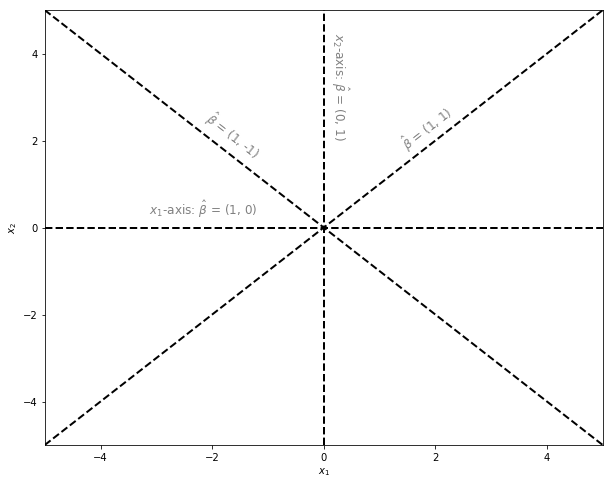

In [2]:
# plot lines in the plane
ablines = [([-5, -5], [5, 5]),
           ([-5, 0], [5, 0]),
           ([0, -5], [0, 5]),
           ([-5, 5], [5, -5])]
for a_coords, b_coords in ablines:
    abline(a_coords, b_coords, ls='--', c='k', lw=2)

# labels
label_abline([-5, 5], [5, -5], '$\hat{\\beta}$ = (1, -1)', -2, 1.5)
label_abline([-5, -5], [5, 5], '$\hat{\\beta}$ = (1, 1)', 1.5, 1.7)
label_abline([-5, 0], [5, 0], ' $x_1$-axis: $\hat{\\beta}$ = (1, 0)', -3, 0.2)
label_abline([0, 5], [0, -5], '$x_2$-axis: $\hat{\\beta}$ = (0, 1)', 0.3, 2)

plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.xlim(-5, 5)
plt.ylim(-5, 5);

The goal of sufficient dimension reduction is to identify the line that contains all the information about $y$. In this example that would be the $x_1$-axis, since $y = x_1^2$ is a function of only $x_1$. By dropping $x_2$ from our analysis we would not lose any information about $y$, since $y$ does not depend on $x_2$.

Now you may have notices that each subspace is labeled with a vector $\hat{\beta}$. This vector tells us the direction of the line. More importantly, $\hat{\beta}$ can be used to project any point in the plane onto that line. We just take the dot product. For example to project a point onto the $x_1$-axis we let $\hat{\beta} = \begin{pmatrix} 1 \\ 0 \end{pmatrix}$, so that $\hat{\beta}^T x = \begin{pmatrix} 1 & 0 \end{pmatrix} \begin{pmatrix} x_1 \\ x_2 \end{pmatrix} = x_1$. It is this $\hat{\beta}$ that is of central importance in sufficient dimension reduction algorithms. If we can estimate $\hat{\beta}$, then we can create a lower dimensional dataset by using $\mathbf{X}\hat{\beta}$ in our analysis instead of $\mathbf{X}$.

Now, let's take a look at the surface $y = x_1^2$ to see how this sort of dimension reduction can help us visualize a dataset. A 3d plot of the surface in the $x_1$-$x_2$-$y$ plane is shown below.

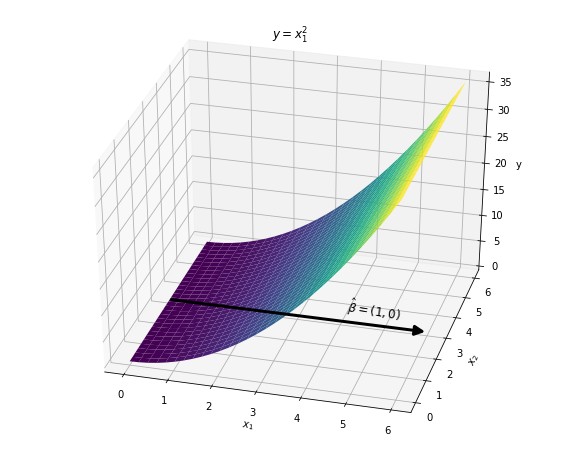

In [3]:
# generate data y = X_1 ** 2 + 0 * X_2
def f(x, y):
    return x ** 2 

x1 = np.linspace(0, 6, 30)
x2 = np.linspace(0, 6, 30)

X1, X2 = np.meshgrid(x1, x2)
Y = f(X1, X2)

# plot 3d surface y = x_1 ** 2
ax = plt.axes(projection='3d')
ax.plot_surface(X1, X2, Y, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')

# An arrow indicating the central subspace
arrow = Arrow3D([0, 6], [3, 3],
                [0, 0], mutation_scale=20, 
                lw=3, arrowstyle="-|>", color="k")
ax.add_artist(arrow)
ax.text(4, 3.5, 0, "$\hat{\\beta} = (1, 0)$", (1, 0, 0), 
        color='k', fontsize=12)

# rotate and label our axes
ax.view_init(35, -75)
ax.set_title('$y = x_1^2$');
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_zlabel('y');

Notice how the surface only varies along the $x_1$-axis. It is completly flat as one traverses along the $x_2$ dimension. This is what we mean when we say $x_2$ carrying no information about $y$. $y$ does not change along this direction. In addition, the direction associated with the $x_1$-axis, $\hat{\beta} = (0, 1)$, is labeled with an arrow. Notice that if we align our view with the $\hat{\beta}$ arrow, then we'd be looking at a two-dimensional plot instead of a three dimensional plot. This is shown below:

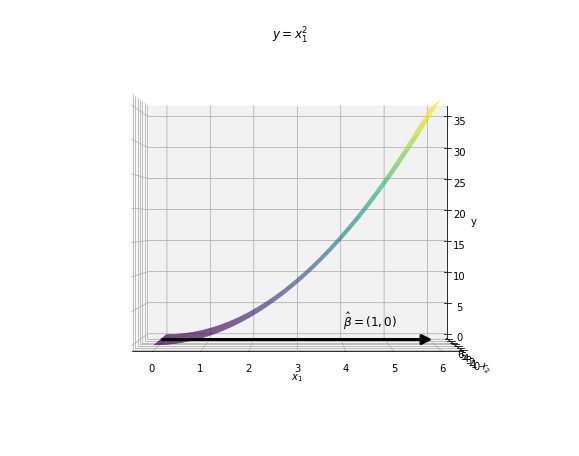

In [4]:
ax = plt.axes(projection='3d')
ax.view_init(0, -90)
ax.plot_surface(X1, X2, Y, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
a = Arrow3D([0, 6], [3, 3],
            [0, 0], mutation_scale=20, 
            lw=3, arrowstyle="-|>", color="k")
ax.add_artist(a)
ax.text(4, 3.5, 2, "$\hat{\\beta} = (1, 0)$", (1, 0, 0), color='k', fontsize=12)
ax.set_title('$y = x_1^2$');
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_zlabel('y');

So by looking at how $y$ varies along the $\hat{\beta}$-directions we've gone from viewing a three-dimensional plot to a two-dimension plot. In other words, we have reduced the number of features from two to one, but the functional form $y = x_1^2$ is still clear. This reduction of features is sufficient!

# Sliced Inverse Regression vs. PCA

Now that we know what sufficient dimension reduction is trying to accomplish, we can look at how it is useful in the analysis of a dataset. In addition, this example is designed to highlight the differences between *unsupervised* and *sufficient* dimension reduction. We will compare the subspace identified by `SlicedInverseRegression` (SIR) in the `imreduce` package with `sklearn`'s `PCA`. SIR is based on sufficient dimension reduction, while PCA is not.

Consider the following data generating process:

$$
y = \sin(0.7 X_1 - 0.7 X_2) + \epsilon
$$
$$
X_i \overset{iid}\sim N(0, 1), \quad \epsilon \overset{iid}\sim N(0, 0.1) 
$$

The dataset has two uncorrelated features, $X_1$ and $X_2$, generated from a normal distribution. The target is the result of applying a sine function to a linear combination of $X_1$ and $X_2$. There is also independent gaussian noise, $\epsilon$, applied on top of the sinusoidal signal. 

Below is a scatterplot of $X_2$ vs. $X_1$. The points are colored according to $y$. Brighter colors correspond to larger values of the target. In addition, the central subspace is labeled with a dashed line.

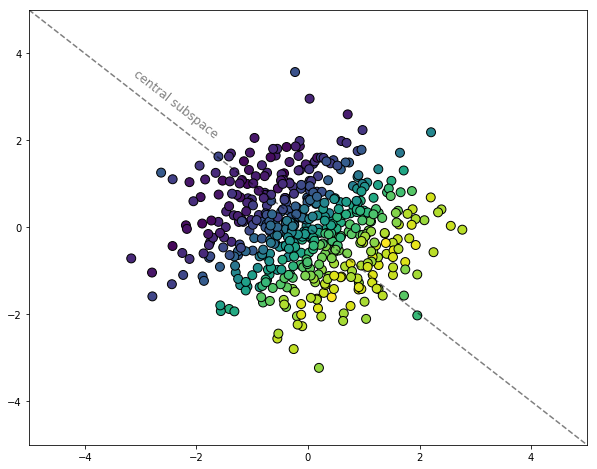

In [5]:
np.random.seed(123)

n_samples = 500
X = np.random.randn(n_samples, 2)
y = np.sin(0.7 * X[:, 0] - 0.7 * X[:, 1]) + 0.1 * np.random.randn(n_samples)

# label the central subspace
line, = plt.plot([-5, 5], [5, -5], ls='--', c='k', alpha=0.5)
label_line(line, 'central subspace', -3, 2)

# scatter plot of points
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', edgecolors='k', s=80)
plt.xlim(-5, 5)
plt.ylim(-5, 5);

Now for whatever reason we want to reduce the number of features in this dataset from two to one. Maybe to better visualize the behavior of $y$. Or maybe because we can only use one feature to build our predictive model. Regardless we decide to compare the one dimensional feature found by SIR with the first principal component of PCA.

Let's take a step back and think about how we would remove features if we knew how the data was generated. If we knew the data generating process above, then we could recognize that the mean of $y$ is completely determined by a single feature:

$$
Z = 0.7X_1 - 0.7X_2.
$$

If $Z = \pi$, then $E[y|Z] = \sin(Z) = \sin(\pi) = 0$. The conditional expectation is a function of a single variable, $Z$, instead of the two variables $X_1$ and $X_2$. Therefore, we should use $Z$ in our analysis instead of $X_1$ and $X_2$. This would reduced the dimension of our dataset from two to one without losing any information about $y$.

Of course, sufficient dimension reduction is thinking in terms of subspaces not derived features. So what subspace is associated with the variable $Z$? In terms of directions, we see that $Z$ is associated with the vector $\hat{\beta} = (0.7, -0.7)$. This is because we can calculate $Z$ by carrying out the product:

$$
Z = \hat{\beta}^T X = \begin{pmatrix} 0.7 & -0.7 \end{pmatrix} \begin{pmatrix} X_1 \\ X_2 \end{pmatrix} = 0.7 X_1 - 0.7 X_2.
$$

Thus we should focus our attention on the one dimensional subspace $\hat{\beta} = (1, -1)$ instead of the two dimensional plane.

Of course we do not know that $\hat{\beta}$ exists, so we set out to use SIR and PCA to estimate it from the data. To fit SIR we import the algorithm from `imreduce` library:

In [6]:
from imreduce import SlicedInverseRegression

Then we create a SIR object. In addition, we tell the algorithm that we are only looking for a single direction. This hyperparameter is denoted by `n_components` to match the API of `PCA`.

In [7]:
sir = SlicedInverseRegression(n_components=1)

Finally we fit the object to the data **as well as the target**, $y$. This is the difference between PCA and SIR. SIR is aware of the target, and will use that information to determine an appropriate subspace. Notice that the fit method returns the object itself, so we can use it for chaining if we desire.

In [8]:
sir.fit(X, y)

SlicedInverseRegression(copy=True, n_components=1, n_slices=10)

At this point we're done! We succesfully fit SIR. Compare that process with fitting PCA to extract a single principal component:

In [9]:
from sklearn.decomposition import PCA

pca = PCA(n_components=1).fit(X)

Both estimators are almost interchangable. The only difference is SIR is aware of the target. Of course, the goal was to extract the directions of our reduced feature space. Just like PCA, SIR stores this result in the `components_` attribute.

In [10]:
pca_direction =  pca.components_[0, :]
sir_direction = sir.components_[0, :]

With our models fit, let's compare the directions found by PCA and SIR:

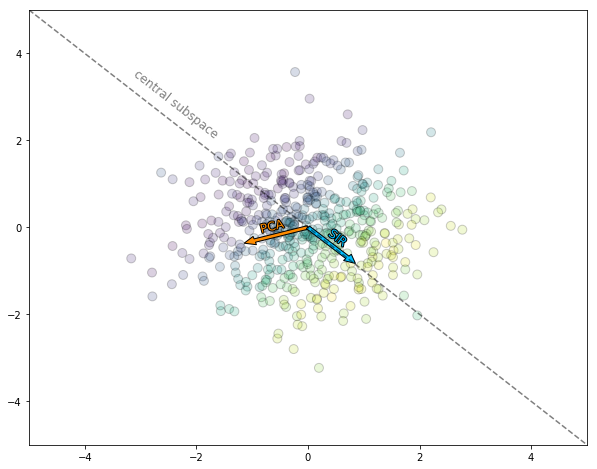

In [11]:
# label the central subspace
line, = plt.plot([-5, 5], [5, -5], ls='--', c='k', alpha=0.5)
label_line(line, 'central subspace', -3, 2)

# scatter plot of points
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', alpha=0.2, edgecolors='k', s=80)
plt.xlim(-5, 5)
plt.ylim(-5, 5)

# label subspaces found by PCA and SIR
arrow_aes = dict(head_width=0.2,
                 head_length=0.2,
                 width=0.08,
                 ec='k')
plt.arrow(0, 0, pca_direction[0], pca_direction[1], fc='darkorange', **arrow_aes)
label_component(pca_direction, 'PCA', -0.7, -0.2, color='darkorange')

plt.arrow(0, 0, sir_direction[0], sir_direction[1], fc='deepskyblue', **arrow_aes)
label_component(sir_direction, 'SIR', 0.5, -0.5, color='deepskyblue');

The orange arrow corresponds to the subspace found by PCA, while the blue arrow corresponds to the subspace found by SIR. Notice how the direction found by PCA has nothing to do with $y$. If it did, then it would point along the color gradient. Instead PCA picks the direction that happens to have the most spread in the data cloud. In fact, this direction is meaningless since the data was generated from an isotropic gaussian blob. However, SIR knows about $y$. Therefore it orients itself nicely along the color gradient, which contains all the information about the target.

To see how this helps visualization, we can project the dataset into the SIR and PCA subspace by using the `transform` method:

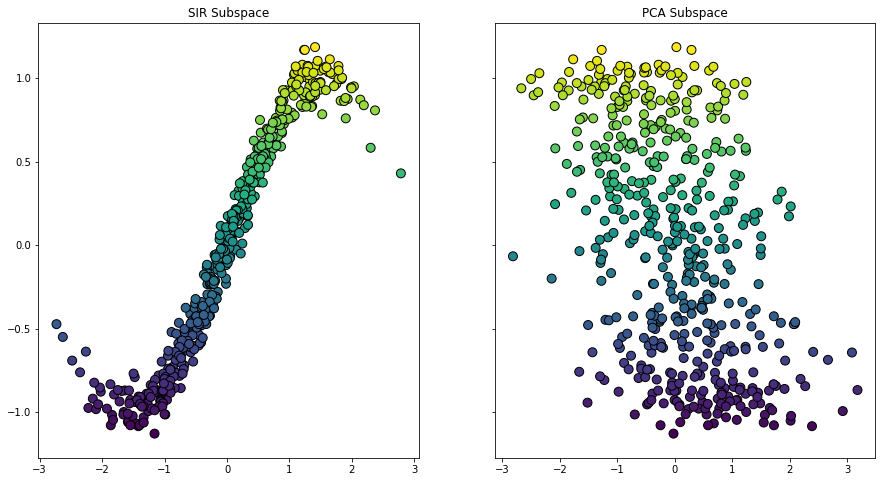

In [12]:
# project data into the subspaces identified by SIR and PCA
X_sir = sir.transform(X)
X_pca = pca.transform(X)

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(15, 8))

ax1.scatter(X_sir[:, 0], y, c=y, cmap='viridis', edgecolors='k', s=80)
ax1.set_title('SIR Subspace')

ax2.scatter(X_pca[:, 0], y, c=y, cmap='viridis', edgecolors='k', s=80)
ax2.set_title('PCA Subspace');

These plots display the power of the SIR algorithm. The sinusoidal pattern that links the features with the target is clearly visiable in the SIR plot on the left. However, this pattern is almost washed out in the PCA plot on the right with data spread almost uniformaly about the scatter plot.

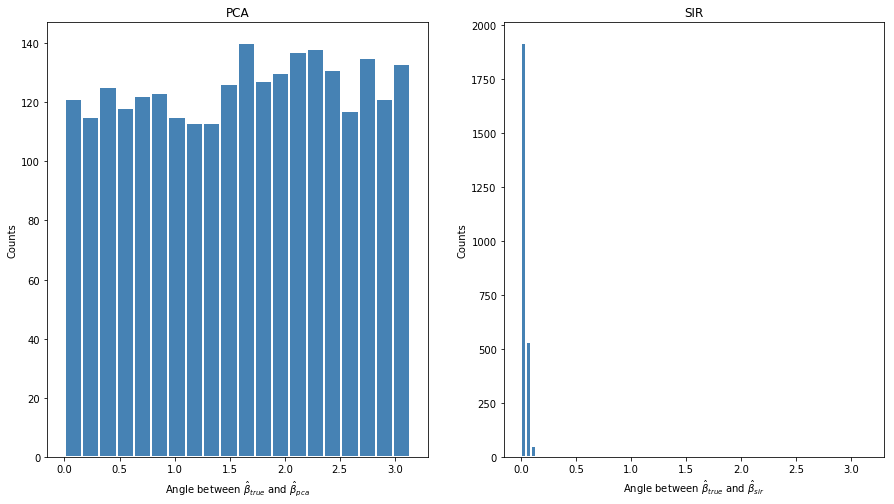

In [163]:
def normalize_it(vec):
    vec = vec.astype(np.float64)
    vec /= np.linalg.norm(vec)
    return vec


def replicate_angle(n_samples=500, n_iter=2500):
    # direction of dimension reducing subspace
    true_direction = normalize_it(np.array([1, -1]))
    
    pca_angle = np.empty(n_iter, dtype=np.float64)
    sir_angle = np.empty(n_iter, dtype=np.float64)
    for i in range(n_iter):
        np.random.seed(i)

        X = np.random.randn(n_samples, 2)
        y = np.sin(0.7 * X[:, 0] - 0.7 * X[:, 1]) + 0.1 * np.random.randn(n_samples)
        
        sir = SlicedInverseRegression(n_components=1).fit(X, y)
        sir_direction = normalize_it(sir.components_[0, :])
    
        pca = PCA(n_components=1).fit(X)
        pca_direction = normalize_it(pca.components_[0, :])
    
        cos_angle = np.dot(pca_direction, true_direction)
        pca_angle[i] = np.arccos(cos_angle)
    
        cos_angle = np.dot(sir_direction, true_direction)
        sir_angle[i] = np.arccos(cos_angle)
    
    return pca_angle, sir_angle

pca_angle, sir_angle = replicate_angle()
    
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize=(15, 8))

ax1.hist(pca_angle, color="steelblue", edgecolor="white", linewidth=2, bins=20)
ax1.set_title('PCA')
ax1.set_xlabel('Angle between $\hat{\\beta}_{true}$ and $\hat{\\beta}_{pca}$')
ax1.set_ylabel('Counts')

ax2.hist(sir_angle, color="steelblue", edgecolor="white", linewidth=2, bins=3)
ax2.set_title('SIR')
ax2.set_xlabel('Angle between $\hat{\\beta}_{true}$ and $\hat{\\beta}_{sir}$')
ax2.set_ylabel('Counts')